### The goal of this notebook is to predict whether a customer would be interested in Vehicle Insurance 

##### The data is as follows:

* `id` — Unique ID for the customer
* `Gender` — Gender of the customer
* `Age` —  Age of the customer
* `Driving_License` — 0 : Customer does not have DL, 1 : Customer already has DL
* `Region_Code` — Unique code for the region of the customer
* `Previously_Insured` — 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* `Vehicle_Age` — Age of the Vehicle
* `Vehicle_Damage` — 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* `Annual_Premium` — The amount customer needs to pay as premium in the year
* `PolicySalesChannel` — Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* `Vintage` — Number of Days, Customer has been associated with the company
* `Response` — 1 : Customer is interested, 0 : Customer is not interested


In [1]:
## set up  SparkSession
##  A SparkSession can be used create DataFrame, register DataFrame as tables, execute SQL over tables, 
## cache tables, and read parquet files. 

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Distributed big data project / PySpark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### Set up SparkSession  [doc](https://spark.apache.org/docs/latest/sql-getting-started.html#starting-point-sparksession)

In [2]:
spark

### Loading Data

In [3]:
## loading the data 
df = spark.read.load("/home/charles/M1/distribured-bigdata-system/project/data/train.csv",
                     format="csv",
                     sep=",", 
                     inferSchema="true",
                     header="true")
df.show(5)
df.printSchema()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  1|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|                26.0|    217|       1|
|  2|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|                26.0|    183|       0|
|  3|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|                26.0|     27|       1|
|  4|  Male| 21|              1|       11.0|                 1|   < 1 Year|            No|       28619.0|               152.0|    203|  

### Data exploration

In [4]:
df = df.dropna(how='any') # first let's drop the NA value

In [5]:
# The column id is not revelant  is just the identifer user. Let's drop it. 

df = df.select('Gender',
               'Age',
               'Driving_License',
               'Region_Code',
               'Previously_Insured',
               'Vehicle_Age',
               'Vehicle_Damage',
               'Annual_Premium',
               'Vintage',
               'Response')

cols = df.columns
df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: integer (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Previously_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)



##### Perform descriptive analytics

In [6]:
df.select('Age',
          'Annual_Premium',
          'Vintage',
         ).describe().show()

+-------+------------------+------------------+------------------+
|summary|               Age|    Annual_Premium|           Vintage|
+-------+------------------+------------------+------------------+
|  count|            381109|            381109|            381109|
|   mean|38.822583565331705|30564.389581458323|154.34739667654136|
| stddev|15.511611018095321|17213.155056980126|  83.6713036265871|
|    min|                20|            2630.0|                10|
|    max|                85|          540165.0|               299|
+-------+------------------+------------------+------------------+



In [7]:
df.select('Gender',
          'Driving_License',
          'Region_Code',
          'Previously_Insured',
          'Vehicle_Age',
          'Vehicle_Damage',
         ).describe().show()

+-------+------+-------------------+------------------+------------------+-----------+--------------+
|summary|Gender|    Driving_License|       Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|
+-------+------+-------------------+------------------+------------------+-----------+--------------+
|  count|381109|             381109|            381109|            381109|     381109|        381109|
|   mean|  null| 0.9978693759528114|26.388807401557035|0.4582101183650871|       null|          null|
| stddev|  null|0.04610954420779957|13.229888025788474| 0.498251198887226|       null|          null|
|    min|Female|                  0|               0.0|                 0|   1-2 Year|            No|
|    max|  Male|                  1|              52.0|                 1|  > 2 Years|           Yes|
+-------+------+-------------------+------------------+------------------+-----------+--------------+



In [8]:
df_pd = df.toPandas()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

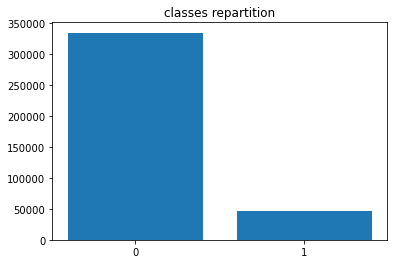

total amount of customer interested in a vehicule insurance, (label 1) 46710
total amount of customer not interested in a vehicule insurance (label 0) 334399


In [36]:
occurences = df_pd['Response'].value_counts()
x = np.arange(2)

fig, ax = plt.subplots()
plt.bar(x, occurences)
plt.xticks(x, ('0','1'))
plt.title('classes repartition')
plt.show()
print('total amount of customer interested in a vehicule insurance, (label 1)', occurences[1])
print('total amount of customer not interested in a vehicule insurance (label 0)', occurences[0])

As we can see above, our response variable is imbalanced. There are several way to deal with imbalanced data. Such as oversampling, undersampling, collecting more data, weight classes. In this notebook, weighted classes will be implement.

### Extracting, transforming and selecting features [doc](https://spark.apache.org/docs/latest/ml-features.html)

In [11]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# categoricalColumns contain all the feature encode as string
categoricalColumns = ['Gender',
                      'Driving_License',
                      'Region_Code',
                      'Previously_Insured',
                      'Vehicle_Age',
                      'Vehicle_Damage',
                     ]

stages = [] # empty list

for categoricalCol in categoricalColumns :
    
    # StringIndexer encodes a string column of labels to a column of label indices
    # If the input column is numeric, StringIndexer cast it to string and index the string values
    stringIndexer = StringIndexer(
        inputCol = categoricalCol, 
        outputCol = categoricalCol + '_Index'
    ) # indexer
    
    # One-hot encoding maps a categorical feature, represented as a label index, to a binary vector with at most a 
    # single one-value indicating the presence of a specific feature value from among the set of all feature values.
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()],
        outputCols=[categoricalCol + "_classVec"]
    )
    
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Response', outputCol = 'label') 

stages += [label_stringIdx]

In [12]:
numericCols = ['Age','Annual_Premium','Vintage']

assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols

# VectorAssembler is a transformer that combines a given list of columns into a single vector column.
# VectorAssembler accepts the following input column types: all numeric types, boolean type, and vector type.
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features')

stages += [assembler]

### Pipeline [doc](https://spark.apache.org/docs/latest/ml-pipeline.html)

In [13]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)

pipelineModel = pipeline.fit(df)

df = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: integer (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Previously_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)



### Weighted column

In [14]:
from pyspark.sql.functions import when,col

ratio = 334399/(334399 + 46710)

def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))

In [15]:
df = df.withColumn('weights', weight_balance(col('Response')))

In [16]:
df.show(5)

+-----+--------------------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+-------+--------+-------------------+
|label|            features|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Vintage|Response|            weights|
+-----+--------------------+------+---+---------------+-----------+------------------+-----------+--------------+--------------+-------+--------+-------------------+
|  1.0|(61,[0,1,2,54,57,...|  Male| 44|              1|       28.0|                 0|  > 2 Years|           Yes|       40454.0|    217|       1|  0.877436638861848|
|  0.0|(61,[0,1,10,54,55...|  Male| 76|              1|        3.0|                 0|   1-2 Year|            No|       33536.0|    183|       0|0.12256336113815203|
|  1.0|(61,[0,1,2,54,57,...|  Male| 47|              1|       28.0|                 0|  > 2 Years|           Yes|       38294.0|     27|       1|  0.877436638861848|
|  0

### Splitting the data for training and testing

In [17]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)

### Classification 

### Decision Tree Classifier  [doc](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

Let implement two models. For each model, one will be implement without weight and one with weight. For the cross-validation optimization, only the weighted model will be implement.

#### regular classifier without weight column

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 6)


dtModel = dt.fit(train)

predictions = dtModel.transform(test)

predictions.select('Age', 'Previously_Insured', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------------------+-----+----------------+----------+--------------------+
|Age|Previously_Insured|label|   rawPrediction|prediction|         probability|
+---+------------------+-----+----------------+----------+--------------------+
| 20|                 0|  0.0|   [474.0,102.0]|       0.0|[0.82291666666666...|
| 21|                 0|  0.0|   [474.0,102.0]|       0.0|[0.82291666666666...|
| 21|                 0|  0.0|   [474.0,102.0]|       0.0|[0.82291666666666...|
| 21|                 0|  0.0|   [474.0,102.0]|       0.0|[0.82291666666666...|
| 21|                 0|  0.0|   [474.0,102.0]|       0.0|[0.82291666666666...|
| 21|                 0|  0.0|   [474.0,102.0]|       0.0|[0.82291666666666...|
| 21|                 0|  0.0|   [474.0,102.0]|       0.0|[0.82291666666666...|
| 22|                 0|  0.0|[16904.0,2816.0]|       0.0|[0.85720081135902...|
| 22|                 0|  0.0|[16904.0,2816.0]|       0.0|[0.85720081135902...|
| 22|                 0|  0.0|[16904.0,2

#### classifier with weight column

In [19]:
from pyspark.ml.classification import DecisionTreeClassifier

dt_weight = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 6, weightCol='weights')


dt_weight_Model = dt_weight.fit(train)

predictions_weight = dt_weight_Model.transform(test)

predictions_weight.select('Age', 'Previously_Insured', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------------------+-----+--------------------+----------+--------------------+
|Age|Previously_Insured|label|       rawPrediction|prediction|         probability|
+---+------------------+-----+--------------------+----------+--------------------+
| 20|                 0|  0.0|[58.4627232628984...|       1.0|[0.38596642636532...|
| 21|                 0|  0.0|[58.4627232628984...|       1.0|[0.38596642636532...|
| 21|                 0|  0.0|[58.4627232628984...|       1.0|[0.38596642636532...|
| 21|                 0|  0.0|[58.4627232628984...|       1.0|[0.38596642636532...|
| 21|                 0|  0.0|[58.4627232628984...|       1.0|[0.38596642636532...|
| 21|                 0|  0.0|[58.4627232628984...|       1.0|[0.38596642636532...|
| 21|                 0|  0.0|[58.4627232628984...|       1.0|[0.38596642636532...|
| 22|                 0|  0.0|[1750.44992377507...|       1.0|[0.45247843715217...|
| 22|                 0|  0.0|[1750.44992377507...|       1.0|[0.45247843715

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [37]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC for the regular classifier : " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under ROC for weighted classifier : " + str(evaluator.evaluate(predictions_weight, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC for the regular classifier : 0.8245911019324608
Test Area Under ROC for weighted classifier : 0.8305248547546038


We can say that our model are pretty equivalent, cause they have really close Area Under ROC. Bet let's go deeper with confusion matrix.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='predicted label', ylabel='true label'>)


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

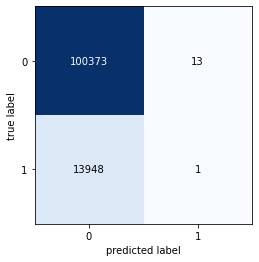

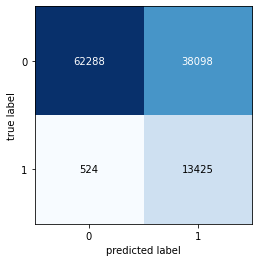

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

predictions_pd = predictions.toPandas()
predictions_weight_pd = predictions_weight.toPandas()

plot_confusion_matrix(confusion_matrix(predictions_pd['label'],predictions_pd['prediction']))

plot_confusion_matrix(confusion_matrix(predictions_weight_pd['label'],predictions_weight_pd['prediction']))

Despite a close area under the ROC for both classifier, the regular classifier only detect one true positive, wereas the weighted model detect 13425 true positive. This mean that the first model is not consistent at all, cause it actually do not answer to the purpose of this notebook which is to predit if a customer would be interesting in a vehicule insurance. Let also consider that, the weighted model predict more false positive than the regular one, but it is still more interesting. 

### Optimisation using Cross-Validation [doc](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation)

In [48]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(dt_weight.impurity, ['gini','entropy'])
             .addGrid(dt_weight.maxDepth, [5, 6, 10])
             .addGrid(dt_weight.minInfoGain, [0.0, 0.2, 0.3])
             .addGrid(dt_weight.minInstancesPerNode, [1, 2])
            ).build()


cv = CrossValidator(estimator=dt_weight,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

# Run cross-validation, and choose the best set of parameters.
cvmodel = cv.fit(train)

# Make predictions on test data. cvModel uses the best model found.
pred = cvmodel.transform(test)

print("Test Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.82998207998208


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

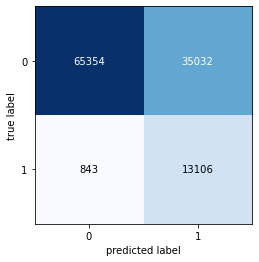

In [49]:
predictions_pd = pred.toPandas()
plot_confusion_matrix(confusion_matrix(predictions_pd['label'],predictions_pd['prediction']))

### Random Forest Classifier [doc](https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier)

As the previous classifier, two models will be implement. One will be implement without weight and one with weight. For the cross-validation optimization, only the weighted model will be implement.

#### regular classifier without weight column

In [50]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

rf_model = rf.fit(train)

# Make predictions.
rf_predictions = rf_model.transform(test)

# Select example rows to display.
rf_predictions.select('Age', 'Previously_Insured', 'label', 'rawPrediction', 'prediction', 'probability').show()


+---+------------------+-----+--------------------+----------+--------------------+
|Age|Previously_Insured|label|       rawPrediction|prediction|         probability|
+---+------------------+-----+--------------------+----------+--------------------+
| 20|                 0|  0.0|[86.6805874896661...|       0.0|[0.86680587489666...|
| 21|                 0|  0.0|[86.6805874896661...|       0.0|[0.86680587489666...|
| 21|                 0|  0.0|[86.6805874896661...|       0.0|[0.86680587489666...|
| 21|                 0|  0.0|[86.6805874896661...|       0.0|[0.86680587489666...|
| 21|                 0|  0.0|[86.6259461225628...|       0.0|[0.86625946122562...|
| 21|                 0|  0.0|[86.6259461225628...|       0.0|[0.86625946122562...|
| 21|                 0|  0.0|[86.6259461225628...|       0.0|[0.86625946122562...|
| 22|                 0|  0.0|[86.6805874896661...|       0.0|[0.86680587489666...|
| 22|                 0|  0.0|[86.6805874896661...|       0.0|[0.86680587489

#### classifier with weight column

In [51]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf_weight = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, weightCol='weights')

rf_model_weight = rf_weight.fit(train)

# Make predictions.
rf_predictions_weight = rf_model_weight.transform(test)

# Select example rows to display.
rf_predictions_weight.select('Age', 'Previously_Insured', 'label', 'rawPrediction', 'prediction', 'probability').show()


+---+------------------+-----+--------------------+----------+--------------------+
|Age|Previously_Insured|label|       rawPrediction|prediction|         probability|
+---+------------------+-----+--------------------+----------+--------------------+
| 20|                 0|  0.0|[35.8407473579595...|       1.0|[0.35840747357959...|
| 21|                 0|  0.0|[35.7333327164629...|       1.0|[0.35733332716462...|
| 21|                 0|  0.0|[35.7957528199393...|       1.0|[0.35795752819939...|
| 21|                 0|  0.0|[35.8407473579595...|       1.0|[0.35840747357959...|
| 21|                 0|  0.0|[35.8882115692646...|       1.0|[0.35888211569264...|
| 21|                 0|  0.0|[36.4446826464323...|       1.0|[0.36444682646432...|
| 21|                 0|  0.0|[36.1388017994083...|       1.0|[0.36138801799408...|
| 22|                 0|  0.0|[35.7029337748159...|       1.0|[0.35702933774815...|
| 22|                 0|  0.0|[35.5944296768847...|       1.0|[0.35594429676

In [58]:
print("Test Area Under ROC for the regular classifier : " + str(evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under ROC for the weight classifier : " + str(evaluator.evaluate(rf_predictions_weight, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC for the regular classifier : 0.815397548258189
Test Area Under ROC for the weight classifier : 0.8376749219944485


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

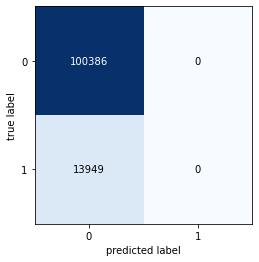

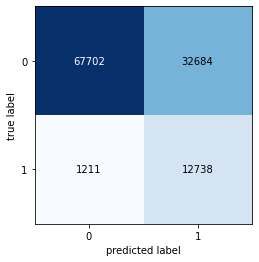

In [55]:
predictions_pd = rf_predictions.toPandas()
predictions_weight_pd = rf_predictions_weight.toPandas()


plot_confusion_matrix(confusion_matrix(predictions_pd['label'],predictions_pd['prediction']))

plot_confusion_matrix(confusion_matrix(predictions_weight_pd['label'],predictions_weight_pd['prediction']))

The confusion matrix of the regular model is quiet interesting, cause it got a good area under the roc, but he classify all the input in the same label. Which the main problem of imbalanced data. That's why, it is always interesting to have look to the data and try differents metrics, in order to find the solution that fit the best our purpose.

### Optimisation using cross validation 

In [53]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf_weight.impurity, ['gini','entropy'])
             .addGrid(rf_weight.maxDepth, [5, 10, 15])
             .addGrid(rf_weight.numTrees, [20, 100, 200])
            ).build()


cv = CrossValidator(estimator=rf_weight, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvmodel = cv.fit(train)
pred = cvmodel.transform(test)

print("Test Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8479879947437587


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

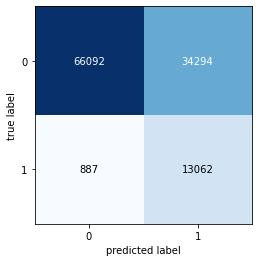

In [54]:
predictions_pd = pred.toPandas()
plot_confusion_matrix(confusion_matrix(predictions_pd['label'],predictions_pd['prediction']))

### CONCLUSION : 

According to the cross-validation, the classifier that offer the best trade-off between true-positif and true-negatif is the Random Forest classifier.